In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c santander-customer-transaction-prediction

 90% 225M/250M [00:01<00:00, 185MB/s]
100% 250M/250M [00:01<00:00, 196MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import six.moves.urllib as urllib
import sklearn
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve,auc
import lightgbm as lgb
from tqdm import tqdm
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [ ]:
! unzip santander-customer-transaction-prediction.zip

Archive:  santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train=pd.read_csv('/content/train.csv')
train.head(2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [ ]:
test=pd.read_csv('/content/test.csv')
test.head(2)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [ ]:
test=pd.read_csv('/content/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [ ]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [ ]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Train data have shape of 200k * 202 where 202 columns are idcode,target,var_0 to var_199.
Test data have shape of 200k * 201 where 201 columns are idcode and var_0 to var_199 

**Check For Null Value**

In [ ]:
train.isnull().any().sum()

0

In [ ]:
test.isnull().any().sum()

0

As we check for null values present in dataset we found sum value as 0 which represenent there is no null value

In [ ]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [ ]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


# Exploratory Data Analysis (EDA)

In [ ]:
eda_df=train.copy()

In [ ]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [ ]:
eda_df.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [ ]:
eda_df=train.copy()

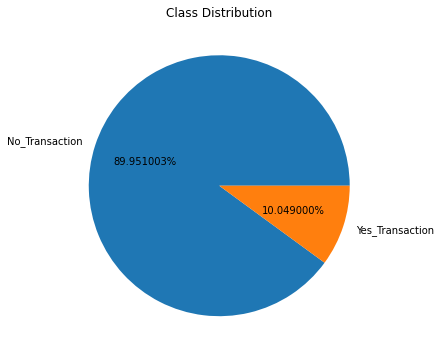

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(
    eda_df['target'].value_counts(),
    autopct='%2f%%',
    labels=['No_Transaction','Yes_Transaction'],
    )
plt.title('Class Distribution')
plt.show()

As It can be observered from the pie chart of class distribution that 89.95% of train data is not make transaction( represent 0 ) and 10.04% of train data is used to make transaction in future .So there are highly data imbalance present in train sample

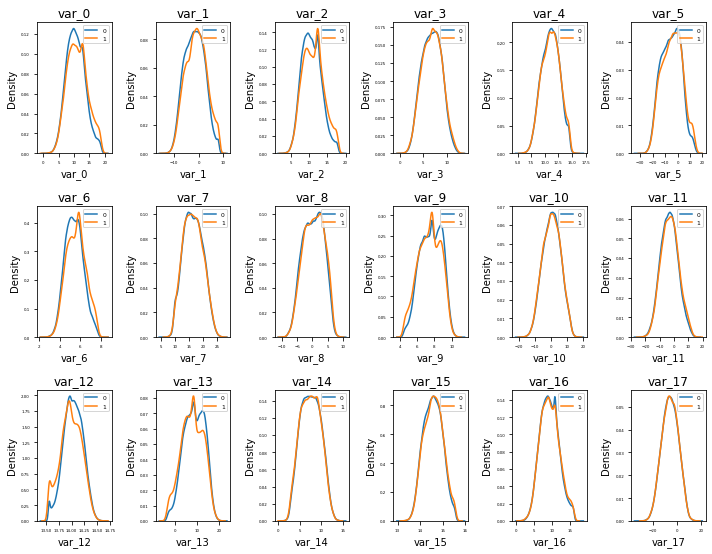

In [ ]:
plt.figure(figsize=(10,10))
target0 = eda_df.loc[eda_df['target'] == 0]
target1 = eda_df.loc[eda_df['target'] == 1]
for i,column in enumerate(eda_df.columns[2:20]):
    plt.subplot(4,6,i+1)
    sns.kdeplot(data=target0[column],label='0')
    sns.kdeplot(data=target1[column],label='1')
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=4)
    plt.tick_params(axis='y', which='major', labelsize=4)
    plt.legend(loc=1, prop={'size': 6})
    plt.title(column)
plt.tight_layout()
plt.show()

As we plot kdeplot for bivariate distributions using kernel density estimation of target 0 and target 1 of some sample columns we found out they follow approx same distribution 

Here we use Kdeplot becuse we want to check distribution density for both classes per columns

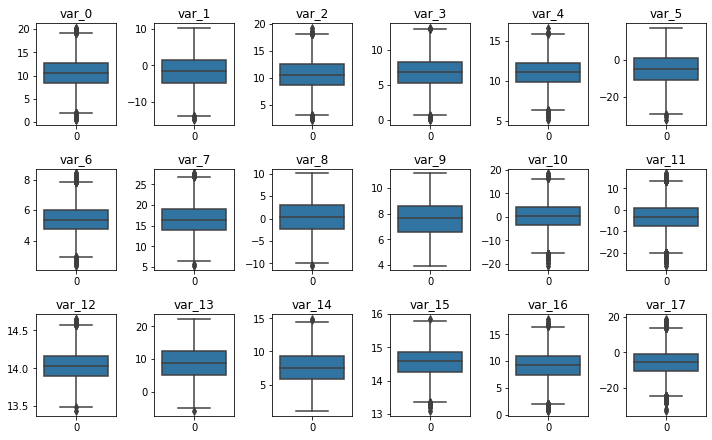

In [ ]:
plt.figure(figsize=(10,8))
for i,column in enumerate(eda_df.columns[2:20]):
    plt.subplot(4,6,i+1)
    sns.boxplot(data=eda_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

We plot boxplot to check if there are outliers persents on every column features and we found only some of columns have outliers and those probably will not impact on model performance

In [ ]:
corr=eda_df.corr()
corr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


Text(0.5, 1.0, 'Correlation Matrix')

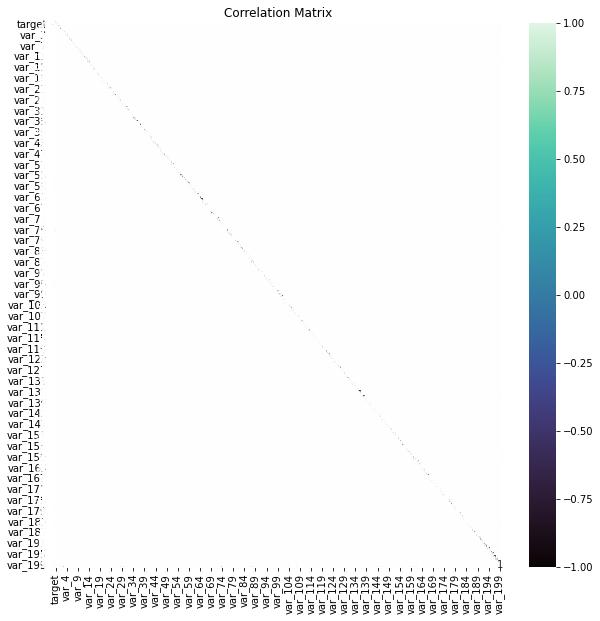

In [ ]:
corr=eda_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,vmin=-1.0,cmap='mako')#here vmin=-1.0 represent person'correlation coefficent can take minimum -1.o value
plt.title('Correlation Matrix')

As we plot heatmap for correlation between given 200features we found that there are no  significant correlation between features 

In [ ]:
corr.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,...,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.005189,0.005265,0.005253,0.005371,0.004928,0.004980,0.005307,0.005429,0.005006,0.005022,...,0.005247,0.005302,0.004641,0.005048,0.004695,0.004997,0.005243,0.004746,0.004756,0.004964
std,0.077967,0.070668,0.070659,0.070681,0.070574,0.070571,0.070582,0.070721,0.070562,0.070580,...,0.070685,0.070640,0.070674,0.070582,0.070608,0.070605,0.070582,0.070641,0.070705,0.070600
min,-0.080917,-0.007402,-0.008855,-0.008795,-0.007140,-0.007080,-0.005686,-0.008958,-0.005396,-0.005311,...,-0.007029,-0.007798,-0.042858,-0.017709,-0.022838,-0.007932,-0.006192,-0.035303,-0.053000,-0.005923
25%,-0.024510,-0.001754,-0.002041,-0.001803,-0.001534,-0.001448,-0.001274,-0.001913,-0.001411,-0.001461,...,-0.001942,-0.001600,-0.001759,-0.001678,-0.001571,-0.001655,-0.001561,-0.002130,-0.001639,-0.001837
50%,0.002215,0.000274,0.000303,0.000480,-0.000144,-0.000004,0.000147,0.000411,0.000057,0.000089,...,0.000169,-0.000022,-0.000035,0.000252,-0.000270,0.000076,-0.000028,0.000060,-0.000194,-0.000011
75%,0.027524,0.001939,0.001956,0.002280,0.001459,0.001421,0.001875,0.002343,0.001566,0.001669,...,0.002205,0.001802,0.001812,0.001769,0.001341,0.001763,0.001940,0.001928,0.002005,0.001372
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Correlation values between features are significantly low  as u can see all features correlation mean value is approx 0.005

In [ ]:
features=eda_df.columns[2:202]

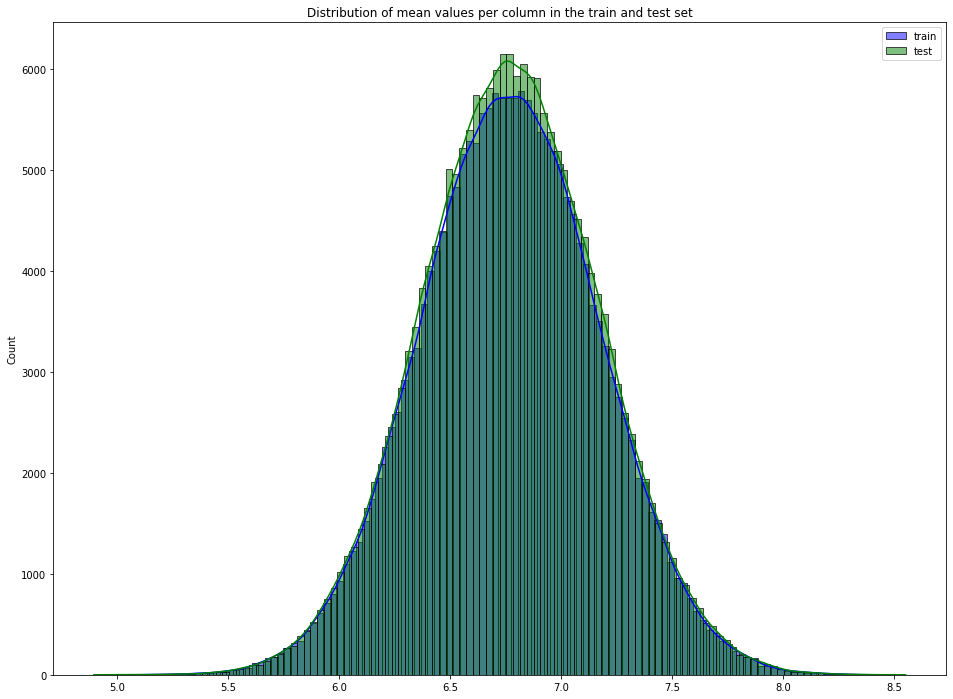

In [ ]:
plt.figure(figsize=(16,12))
plt.title('Distribution of mean values per column in the train and test set')
sns.histplot(train[features].mean(axis=1),color='blue',kde=True,bins=120,label='train')
sns.histplot(test[features].mean(axis=1),color='green',kde=True,bins=120,label='test')
plt.legend()
plt.show()

Mean value distribution of train and test data sample are same and guassian 

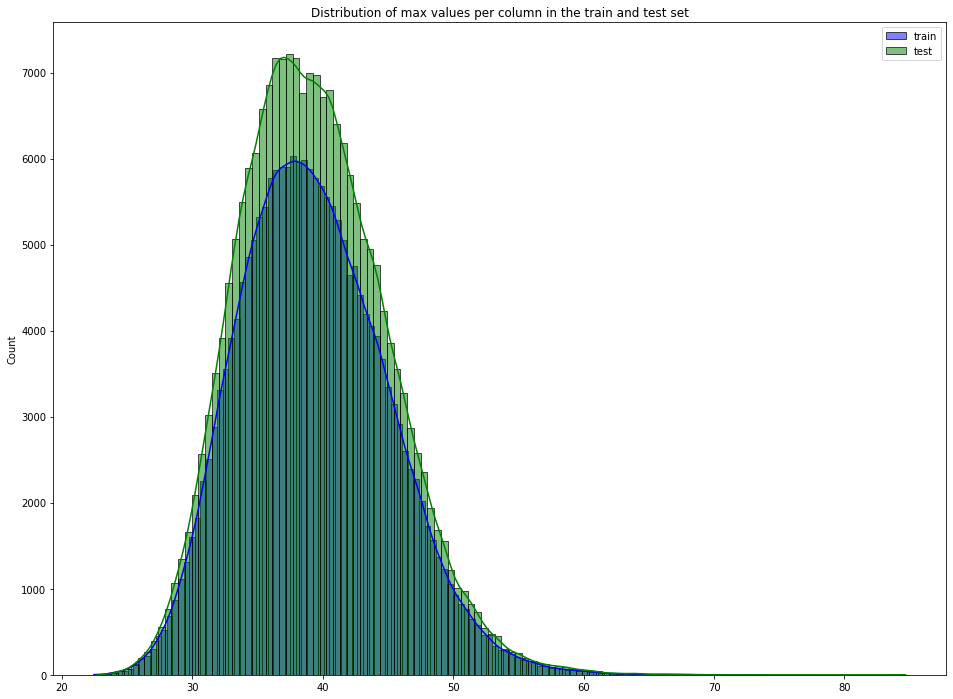

In [ ]:
plt.figure(figsize=(16,12))
plt.title('Distribution of max values per column in the train and test set')
sns.histplot(train[features].max(axis=1),color='blue',kde=True,bins=120,label='train')
sns.histplot(test[features].max(axis=1),color='green',kde=True,bins=120,label='test')
plt.legend()
plt.show()

1. Max value distribution of train and test data distribution is left skewed.
2. There are more mean centric max values present in test data

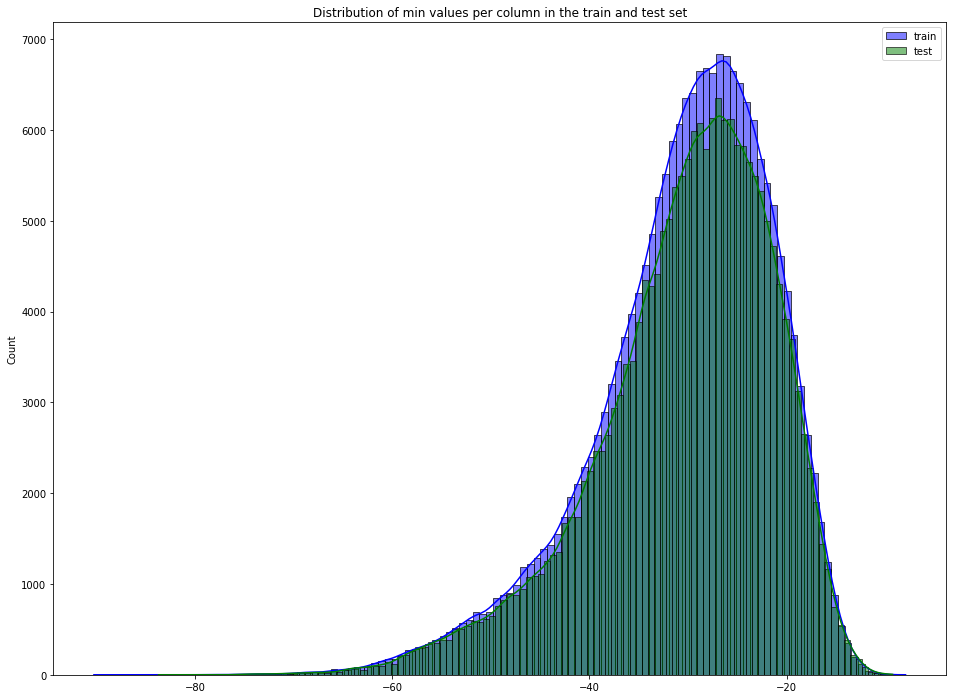

In [ ]:
plt.figure(figsize=(16,12))
plt.title('Distribution of min values per column in the train and test set')
sns.histplot(train[features].min(axis=1),color='blue',kde=True,bins=120,label='train')
sns.histplot(test[features].min(axis=1),color='green',kde=True,bins=120,label='test')
plt.legend()
plt.show()

1. There are lot of variation of spectra of minimum value  present in train data sample.
2. Minimum Value Distribution of train and test data sample is right skewed.

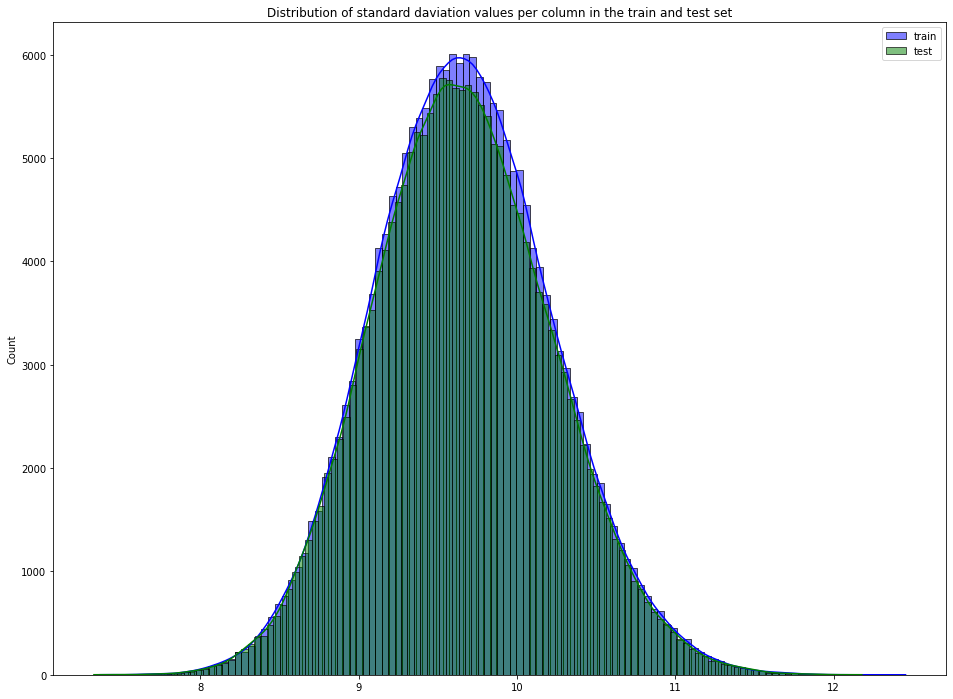

In [ ]:
plt.figure(figsize=(16,12))
plt.title('Distribution of standard daviation values per column in the train and test set')
sns.histplot(train[features].std(axis=1),color='blue',kde=True,bins=120,label='train')
sns.histplot(test[features].std(axis=1),color='green',kde=True,bins=120,label='test')
plt.legend()
plt.show()

Histogram plot distribution of standard deviation of train test data is looklike Guassian distribution.

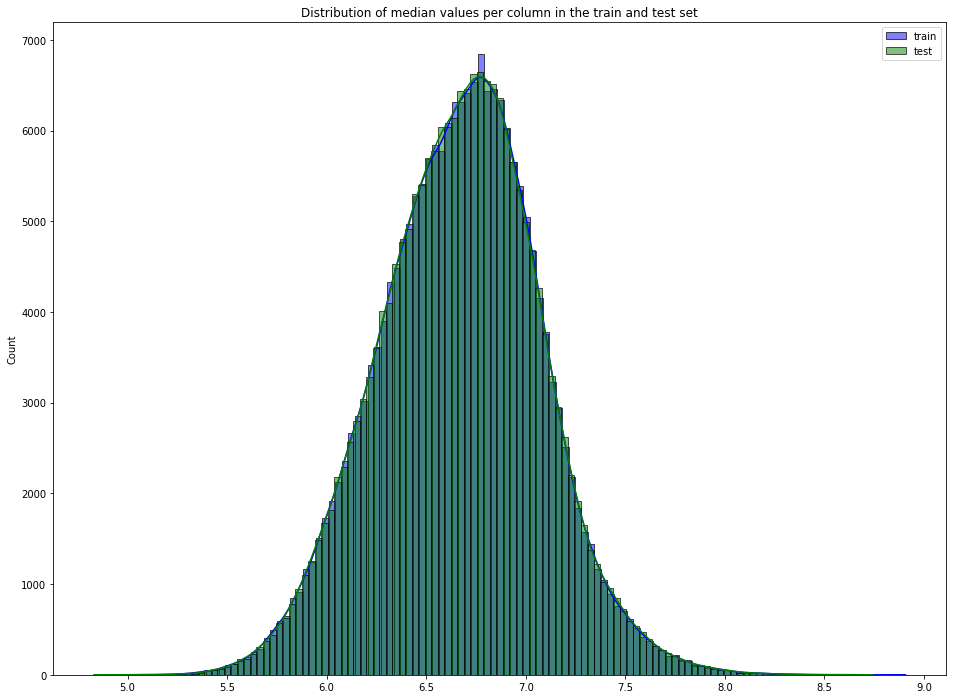

In [ ]:
plt.figure(figsize=(16,12))
plt.title('Distribution of median values per column in the train and test set')
sns.histplot(train[features].median(axis=1),color='blue',kde=True,bins=120,label='train')
sns.histplot(test[features].median(axis=1),color='green',kde=True,bins=120,label='test')
plt.legend()
plt.show()

Medians values distribution of target and test are approximate and kind of gaussian distribution.

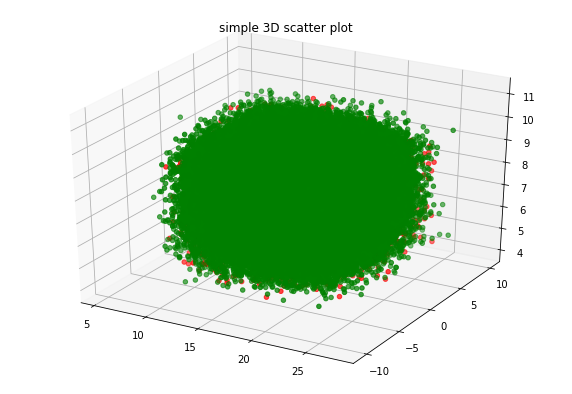

In [ ]:
target0=eda_df.loc[eda_df['target']==0]
target1=eda_df.loc[eda_df['target']==1]
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

x_0,y_0,z_0=target0['var_7'],target0['var_8'],target0['var_9']
x_1,y_1,z_1=target1['var_7'],target1['var_8'],target1['var_9']

# Creating plot
ax.scatter3D(x_0,y_0,z_0, color = "g",)
ax.scatter3D(x_1,y_1,z_1, color = "r")
plt.title("simple 3D scatter plot")
# show plot
plt.show()

Target distribution of value 0 and 1 are overlaped per columns.So we can not easily distinguish as value wise

In [ ]:
eda_df.corr()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [ ]:
eda_df.corr()


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


##Univariate Analysis

In [ ]:
eda_df.corrwith(eda_df["target"]).sort_values(ascending=False)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Length: 201, dtype: float64

As we calculate singe feature correlation value with respect to target we are getting value max value as 0.06 which represent very weak correlation